In [ ]:
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
import sys
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [ ]:
def initial_learning_rate(epoch):
    if (epoch >= 0) and (epoch < 300):
        return 0.01
    if (epoch >= 300) and (epoch < 800):
        return 0.001
    if (epoch >= 800) and (epoch < 1500):
        return 0.001
    else:
        return 0.0001

In [ ]:
class PDENet:
    # Init
    def __init__(self, xb, yb, ub, vb, x, y, layers):
        
        # Xb = np.concatenate([xb, yb, ub], 1)
        # X = np.concatenate([x, y], 1)
        self.dim = 2
        
        # self.lb = X.min(0)
        # self.ub = X.max(0)

        # self.Xb = Xb        
        # self.X = X
        
        # self.xb = Xb[:,0:1]
        # self.yb = Xb[:,1:2]
        # self.ub = Xb[:,2:3]
        # self.x = X[:,0:1]
        # self.y = X[:,1:2]
        
        self.xb = xb
        self.yb = yb
        self.ub = ub
        self.vb = vb
        self.x = x
        self.y = y
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.init_NN(layers)
        
        # Initialize parameters
        # self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        # self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.xyb_tf = tf.placeholder(tf.float32, shape=[None, 2, 1])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.vb_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.xy_tf = tf.placeholder(tf.float32, shape=[None, 2, 1])
        
        self.ub_pred, self.vb_pred, self.p_pred, _ , _ , _ , _ , _ , _  = self.net_uv(self.xyb_tf)
        _ , _ , _ , self.f_u_pred, self.f_v_pred, self.div_u_pred = self.net_f_uv(self.xy_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.ub_pred - self.ub_tf) + tf.square(self.vb_pred - self.vb_tf)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred) + tf.square(self.f_v_pred) + tf.square(self.div_u_pred))
                                   
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 3000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        # self.opt = tf.contrib.opt.ScipyOptimizerInterface(self.loss,method='SLSQP', options={'maxiter': 1000}) 
        self.lossHistogram = []
        # self.adaptive_rate = tf.placeholder(tf.float32)
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate= 0.001, epsilon=0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def init_NN(self, layers):
        dim = self.dim
        weights = []
        biases = []
        num_layers = len(layers)
        W = self.xavier_init(size=[layers[0], dim])
        b = tf.Variable(tf.zeros([layers[0],1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b)
        for l in range(1,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l]])
            b = tf.Variable(tf.zeros([layers[l],1], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)  
        W = self.xavier_init(size=[3, layers[-1]])
        b = tf.Variable(tf.zeros([3,1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b) 
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def net_nn(self, X, weights, biases):
        num_layers = len(self.layers)
        H = X
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(W, H), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(W, H), b)
        return Y

    def net_uv(self, xy):
        # uvp = self.net_nn(tf.concat([x,y], 1), self.weights, self.biases)
        uvp = self.net_nn(xy, self.weights, self.biases)
        # psi = psi_p[:,0]
        # p = psi_p[:, 1]

        # u = tf.gradients(psi, y)[0]
        # v = - tf.gradients(psi, x)[0]
        u = uvp[:,0]
        v = uvp[:,1]
        p = uvp[:,2]
        u_x = tf.gradients(u, xy)[0][:,0]
        u_y = tf.gradients(u, xy)[0][:,1]
        v_x = tf.gradients(v, xy)[0][:,0]
        v_y = tf.gradients(v, xy)[0][:,1]
        p_x = tf.gradients(p, xy)[0][:,0]
        p_y = tf.gradients(p, xy)[0][:,1]

        return u, v, p, u_x, u_y, v_x, v_y, p_x, p_y
        
    def net_f_uv(self, xy):
        u, v, p, u_x, u_y, v_x, v_y, p_x, p_y = self.net_uv(xy)

        u_xx = tf.gradients(u_x, xy)[0][:,0]
        u_yy = tf.gradients(u_y, xy)[0][:,1]

        v_xx = tf.gradients(v_x, xy)[0][:,0]
        v_yy = tf.gradients(v_y, xy)[0][:,1]

        f_u = -0.025*(u_xx + u_yy) + (u*u_x + v*u_y) + p_x
        f_v = -0.025*(v_xx + v_yy) + (u*v_x + v*v_y) + p_y
        div_u = u_x + v_y
        
        return u, v, p, f_u, f_v, div_u
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        self.lossHistogram.append(loss)

    # def getbatch(self, data, n_batch, batch_size=10):
    #     data_batch = data[batch_size*n_batch:batch_size*(n_batch+1)]
    #     return data_batch
      
    def train(self, nIter): 

        tf_dict = {self.xyb_tf: np.concatenate([self.xb, self.yb], 1), self.ub_tf: self.ub, self.vb_tf: self.vb,
                   self.xy_tf: np.concatenate([self.x, self.y], 1)}

        start_time = time.time()
        for it in range(nIter):
            # loss_ite = 0.0
            # for n_batch in range(int(self.x.size/10)):
            #     tf_dict = {self.xb_tf: self.getbatch(self.xb, n_batch), self.yb_tf: self.getbatch(self.yb, n_batch),
            #                self.ub_tf: self.getbatch(self.ub, n_batch), self.vb_tf: self.getbatch(self.vb, n_batch),
            #             self.x_tf: self.getbatch(self.x, n_batch), self.y_tf: self.getbatch(self.y, n_batch)}
            #     self.sess.run(self.train_op_Adam, tf_dict)
            #     loss_value = self.sess.run(self.loss, tf_dict)
            #     loss_ite = loss_ite + loss_value
            
            self.sess.run(self.train_op_Adam, tf_dict)
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            self.lossHistogram.append(loss_value)
            start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        # self.opt.minimize(self.sess,
        #                         feed_dict = tf_dict,
        #                         fetches = [self.loss],
        #                         loss_callback = self.callback)
            
    
    def predict(self, x, y):
        
        tf_dict = {self.xyb_tf: np.concatenate([x, y], 1)}
        
        u = self.sess.run(self.ub_pred, tf_dict)
        v = self.sess.run(self.vb_pred, tf_dict)
        p = self.sess.run(self.p_pred, tf_dict)

        # tf_dict = {self.x_tf: x, self.y_tf: y}
        
        # f_u = self.sess.run(self.f_u_pred, tf_dict)
        # f_v = self.sess.run(self.f_v_pred, tf_dict)

        return u, v, p

In [ ]:
class sampling_from_rectangle:
	def __init__(self, x_range, y_range):
		self.x_range = x_range
		self.y_range = y_range

	def interior_samples(self, batchsize):
		int_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
		int_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)

		return int_draw_x, int_draw_y

	def boundary_samples(self, batchsize):
		a = self.x_range[1]-self.x_range[0]
		b = self.y_range[1]-self.y_range[0]

		draw_perimeter = np.random.uniform(0, 2*(a + b), batchsize)

		draw = []

		for i in draw_perimeter:
			if i < a:
				draw.append([i+ self.x_range[0], self.y_range[0]])
			elif a <= i and i < a+b:
				draw.append([self.x_range[1], (i-a) + self.y_range[0]])
			elif a+b <= i and i < 2*a+b:
				draw.append([self.x_range[1] - (i-(a+b)), self.y_range[1]])
			elif 2*a+b <= i and i<= 2*a+2*b:
				draw.append([self.x_range[0], self.y_range[1] - (i-(2*a+b))])

		return np.array(draw)[:, 0], np.array(draw)[:, 1]

In [ ]:
sampler = sampling_from_rectangle([-0.5, 0.5], [-0.5, 0.5])
N = 2500;
filename = 'data_'

nu = 0.025
lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y = sampler.boundary_samples(N)
    int_draw_x, int_draw_y = sampler.interior_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], bou_draw_x[i], bou_draw_y[i], 1.0-np.exp(lambda_1*bou_draw_x[i])*np.cos(2.0*np.pi*bou_draw_y[i]), lambda_1/(2.0*np.pi)*np.exp(lambda_1*bou_draw_x[i])*np.sin(2.0*np.pi*bou_draw_y[i])])

dataset = np.genfromtxt('data_2500.csv', delimiter=',')
print(dataset)

[[ 6.28699753e-02 -4.60827396e-01 -4.34790114e-01  5.00000000e-01
   2.52047816e+00 -2.85608612e-17]
 [ 3.92092725e-02  6.37351115e-03 -5.00000000e-01 -4.87179416e-01
   2.61384943e+00  1.99835091e-02]
 [-4.00567943e-01  2.27736396e-01 -5.00000000e-01 -4.22301193e-01
   2.42995719e+00  1.16481681e-01]
 ...
 [ 2.75810131e-01  2.08471284e-01  2.30585687e-01  5.00000000e-01
   1.80073536e+00 -1.50411180e-17]
 [-6.05847931e-02  2.96578843e-01  1.15243291e-01 -5.00000000e-01
   1.89488091e+00  1.68095604e-17]
 [ 8.39548529e-02  1.54341952e-01 -3.79643849e-01 -5.00000000e-01
   2.44177958e+00  2.70825768e-17]]


In [ ]:
def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    vb = []
    nu = 0.025
    lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
    for row in data:
        if (row[0] == 0.5 or row[1] == 0.5 or row[0] == -0.5 or row[1] == -0.5):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(1.0-np.exp(lambda_1*row[0])*np.cos(2.0*np.pi*row[1]))
            vb.append(lambda_1/(2.0*np.pi)*np.exp(lambda_1*row[0])*np.sin(2.0*np.pi*row[1]))
        else:
            x.append(row[0])
            y.append(row[1])
            
    return np.array(x), np.array(y), np.array(xb), np.array(yb), np.array(ub), np.array(vb)

In [ ]:
# dataset = np.genfromtxt('modified_triangle_data_[-0.5,0.5]_[0,1]_50_50.txt', delimiter=',')
dataset = np.genfromtxt('data_2500.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
xb = dataset[:,2]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,3]
yb = yb.reshape((yb.size, 1, 1))
ub = dataset[:,4]
ub = ub.reshape((ub.size, 1))
vb = dataset[:,5]
vb = vb.reshape((ub.size, 1))
layers = [16, 16]



In [154]:
dataset = np.genfromtxt('triangle_data_[-0.5,0.5]_[-0.5,0.5]_(50x50).txt', delimiter=',')
# dataset = np.genfromtxt('data_2500.csv', delimiter=',')
x, y, xb, yb, ub, vb = splitData(dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
vb = vb.reshape((ub.size, 1))
layers = [32, 32, 32, 32, 32]


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Loss: 3.156e+00
Loss: 1.719e+00
Loss: 8.320e-01
Loss: 7.370e-01
Loss: 7.139e-01
Loss: 7.049e-01
Loss: 7.006e-01
Loss: 7.000e-01
Loss: 6.995e-01
Loss: 6.972e-01
Loss: 6.949e-01
Loss: 6.959e-01
Loss: 6.937e-01
Loss: 6.920e-01
Loss: 6.913e-01
Loss: 6.911e-01
Loss: 6.905e-01
Loss: 6.896e-01
Loss: 6.883e-01
Loss: 6.874e-01
Loss: 6.864e-01
Loss: 6.853e-01
Loss: 6.845e-01
Loss: 6.831e-01
Loss: 6.800e-01
Loss: 7.293e+00
Loss: 6.888e-01
Loss: 6.772e-01
Loss: 6.820e-01
Loss: 6.754e-01
Loss: 6.701e-01
Loss: 6.624e-01
Loss: 6.574e-01
Loss: 6.550e-01
Loss: 6.365e-01
Loss: 6.426e+00
Loss: 6.436e-01
Loss: 6.141e-01
Loss: 5.895e-01
Loss: 8.940e-01
Loss: 5.243e-01
Loss: 5.265e-01
Loss: 5.067e-01
Loss: 5.194e-01
Loss: 4.894e-01
Loss: 9.230e-01
Loss: 4.772e-01
Loss: 4.679e-01
Loss: 4.558e-01
Loss: 4.725e-01
Loss: 4.419e-01
Loss: 4.195e-01
Loss: 3.970e-01
Loss: 3.874e-01
Loss: 3.476e-01
Loss: 3.342e-01
Loss: 3.104e

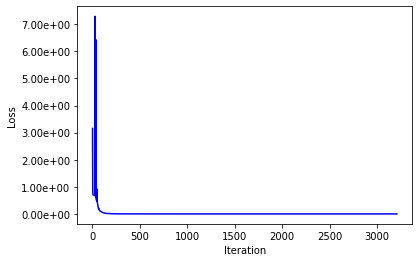

In [155]:
model = PDENet(xb, yb, ub, vb, x, y, layers)
start_time = time.time()                
model.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i + 1 for i in range(epochs)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_epochs,losses, color = 'blue')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')
plt.show()

a_file = open("Loss31.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

In [146]:
a_file = open("Loss31.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

In [147]:
def exact_solution(x, y):
    nu = 0.025
    lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
    u = 1.0 - tf.math.exp(lambda_1*x)*tf.math.cos(2.0*np.pi*y)
    v = lambda_1/(2.0*np.pi)*tf.math.exp(lambda_1*x)*tf.math.sin(2.0*np.pi*y)
    return u, v
def splitDataTest(data):
    x = []
    y = []
    for row in data:
        x.append(row[0])
        y.append(row[1])
    return np.array(x), np.array(y)

In [ ]:
sampler = sampling_from_rectangle([-0.5, 0.5], [-0.5, 0.5])
N = 200;
filename = 'data_'

nu = 0.025
lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y = sampler.boundary_samples(N)
    int_draw_x, int_draw_y = sampler.interior_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], bou_draw_x[i], bou_draw_y[i], 1.0-np.exp(lambda_1*bou_draw_x[i])*np.cos(2.0*np.pi*bou_draw_y[i]), lambda_1/(2.0*np.pi)*np.exp(lambda_1*bou_draw_x[i])*np.sin(2.0*np.pi*bou_draw_y[i])])

dataset = np.genfromtxt('data_200.csv', delimiter=',')
print(dataset)

In [157]:
dataset = np.genfromtxt('data_200.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
xb = dataset[:,2]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,3]
yb = yb.reshape((yb.size, 1, 1))
ub = dataset[:,4]
ub = ub.reshape((ub.size, 1))
vb = dataset[:,5]
vb = vb.reshape((ub.size, 1))

In [158]:
u_pred, v_pred, _ = model.predict(x, y)
u_e, v_e = exact_solution(x, y)

In [159]:
ub_pred, vb_pred, _ = model.predict(xb, yb)

In [160]:
u_e = tf.reshape(u_e, [x.size, 1])
v_e = tf.reshape(v_e, [x.size, 1])
LossL2 = tf.reduce_mean(tf.square(u_pred - u_e) + tf.square(v_pred - v_e))+  tf.reduce_mean(tf.square(ub_pred - ub) + tf.square(vb_pred - vb))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

1.181563319220105e-06
<class 'numpy.float64'>


In [161]:
LossL2 = tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.0010869973869426298
<class 'numpy.float64'>


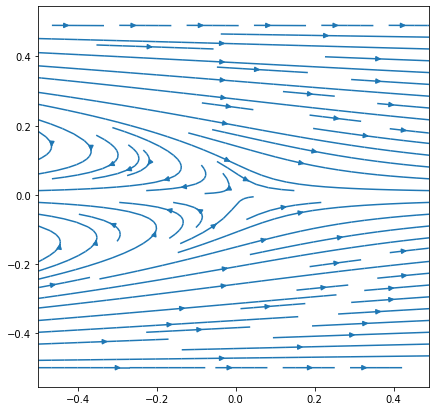

In [162]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
U, V, _  = model.predict(X1, Y1)
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 100))
V = np.reshape(V, (-1, 100))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 
  
# show plot 
plt.show() 

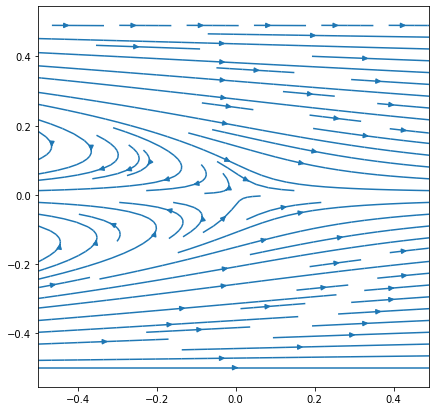

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01]  
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
U, V = exact_solution(X1, Y1)
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01]  
# U = U.flatten()
# V = V.flatten()
# U = np.reshape(U, (-1, 100))
# V = np.reshape(V, (-1, 100))
fig = plt.figure(figsize = (7, 7)) 
with tf.Session() as sess:
    U = np.reshape(U.eval().flatten(), (-1, 100))
    V = np.reshape(V.eval().flatten(), (-1, 100))
    plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 